In [41]:
import controllers
import controlpy
import control_utils
import dynamics_models
import numpy as np
import polytope
import system_id
import tqdm
import uncertainty_utils

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', family='serif')
plt.rc('font', serif='Times')
plt.rc('font', size=16)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'

## Setup dynamics
$$ \dot{x} = a*sin(cx) +  b*arctan(u) + w$$
$$ w \sim \mathcal{N}(0, \sigma^2)$$

In [42]:
class SineModel(dynamics_models.NonLinearSystem):
    """
    dx/dt = sin(x) + u^(1/3)
    """
    
    def __init__(self, init_state, dt, process_noise):
        super(SineModel, self).__init__(1, 1, init_state, dt, process_noise, use_ode_integrator=True)
        self.a = 15
        self.b = 5
        self.c = 2
        
    def f_continuous(self, state, u):
        return self.a * np.sin(self.c * state) + self.b * np.arctan(u)
    
    def get_jacobians(self, x_bar, u_bar):
        Jx = np.array([self.a * self.c * np.cos(self.c * x_bar)])
        Ju = np.array([self.b / (1 + u_bar ** 2)])
        return Jx, Ju

In [43]:
dt = 0.1
n = 1
m = 1
init_lims = (-5, 5)
process_noise = np.eye(n) * 1
def get_vehicle():
    init_state = np.random.uniform(low=init_lims[0], high=init_lims[1])
    return SineModel(np.array([init_state]), dt, process_noise)
vehicle = get_vehicle()

## Setup Controller

In [44]:
x_bar = np.zeros(n)
u_bar = np.zeros(m)
A, B, C = vehicle.get_linearization(x_bar, u_bar, dt)

Q = np.eye(n)
R = np.eye(m)
K, _, _ = controlpy.synthesis.controller_lqr_discrete_time(A, B, Q, R)

## Run Controller

In [45]:
def sim_traj(vehicle, K, episode_length):
    x_traj = [vehicle.x]
    u_traj = []
    for _ in range(episode_length):
        u = - K @ x_traj[-1]
        x_next = vehicle.f(u)

        x_traj.append(x_next)
        u_traj.append(u)
    return x_traj, u_traj

In [46]:
num_episodes = 10
episode_length = 30
x_trajs = []
u_trajs = []
for i in tqdm.tqdm(range(num_episodes)):
    vehicle = get_vehicle()
    x_traj, u_traj = sim_traj(vehicle, K, episode_length)
    x_trajs.append(x_traj)
    u_trajs.append(u_traj)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 50.64it/s]


## Do Local Linear Regression
$$ x[t+1] = Ax[t] + Bu[t] + x $$ where
$$ A,B,C = \arg \min_{A,B,C} \sum_{i=0}^{N-1}||Ax_i + Bu_i + C - x_{i+1}||_2^2 \mathcal{K}(x_i - \bar{x})$$

In [47]:
h = 5
lamb = 1e-2
model = system_id.LocalLinearModel(n, m, h, lamb)

for x_traj, u_traj in zip(x_trajs, u_trajs):
    model.add_trajectory(x_traj, u_traj)

test_points = np.linspace(*init_lims, num=100)
test_points = test_points.reshape((len(test_points), 1))
test_inputs = - test_points @ K.T
x_test = np.hstack((test_points, test_inputs))

predictions, uncertainties = model.predict(test_points, test_inputs)
uncertainties = ((uncertainties + 1) * process_noise).flatten()
predictions = predictions.flatten()
x_data = model.X
y_data = model.Y

## Plot Learning results

In [48]:
vehicle = get_vehicle()
f_true = lambda x: vehicle.f_discrete(x, - K @ x, dt)
y_true = [f_true(np.array([x])) for x in test_points.flatten()]

Text(0.5,1,'Locally Linear Dynamics')

C:\Users\rohan\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


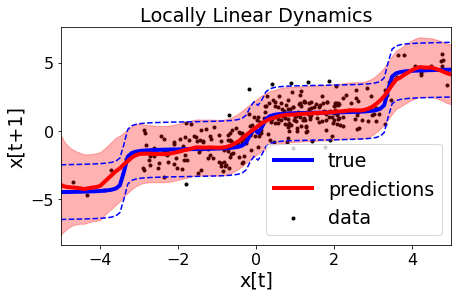

In [49]:
lw = 4
plt.figure(figsize=(7,4))
plt.plot(test_points, y_true, "b", lw=lw, label="true")
hi = y_true + 2 * np.sqrt(process_noise)
lo = y_true - 2 * np.sqrt(process_noise)
plt.plot(test_points, hi, "b--")
plt.plot(test_points, lo, "b--")
plt.scatter(x_data[:,0], y_data[:,0], c="k", marker=".", label="data")

plt.plot(test_points, predictions, "r", lw=lw, label="predictions")
hi = predictions + 2 * np.sqrt(uncertainties)
lo = predictions - 2 * np.sqrt(uncertainties)
plt.fill_between(test_points.flatten(), hi, lo, alpha=0.3, color="r")
plt.xlim(init_lims)
plt.legend()
plt.xlabel("x[t]")
plt.ylabel("x[t+1]")
plt.title("Locally Linear Dynamics")

## Gaussian Process for Full Dynamics
$$ x[t+1] = gp(x[t], u[t]) $$

In [50]:
kernel = RBF(length_scale=1) + WhiteKernel(noise_level=process_noise[0])
gp = GaussianProcessRegressor(kernel=kernel).fit(x_data, y_data)
predictions, covs = gp.predict(x_test, return_cov=True)
uncertainties = np.diag(covs)
predictions = predictions.flatten()

Text(0.5,1,'Gaussian Process Dynamics')

C:\Users\rohan\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


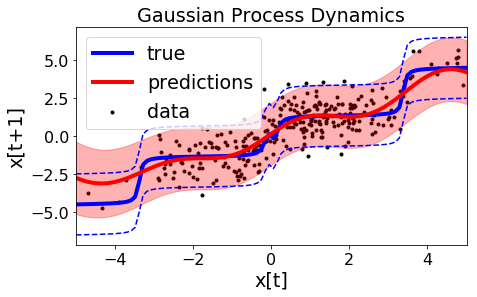

In [51]:
lw = 4
plt.figure(figsize=(7,4))
plt.plot(test_points, y_true, "b", lw=lw, label="true")
hi = y_true + 2 * np.sqrt(process_noise)
lo = y_true - 2 * np.sqrt(process_noise)
plt.plot(test_points, hi, "b--")
plt.plot(test_points, lo, "b--")
plt.scatter(x_data[:,0], y_data[:,0], c="k", marker=".", label="data")

plt.plot(test_points, predictions, "r", lw=lw, label="predictions")
hi = predictions + 2 * np.sqrt(uncertainties)
lo = predictions - 2 * np.sqrt(uncertainties)
plt.fill_between(test_points.flatten(), hi, lo, alpha=0.3, color="r")
plt.xlim(init_lims)
plt.legend()
plt.xlabel("x[t]")
plt.ylabel("x[t+1]")
plt.title("Gaussian Process Dynamics")

## Gaussian Process for Supplemental Dynamics
$$ x[t+1] = Ax[t] + Bu[t] + C + gp(x[t],u[t])$$

In [52]:
def predict_nominal(x_data):
    nominal_predictions = [A @ np.array([x[0]]) + B @ np.array([x[1]] + C) for x in np.rollaxis(x_data, 0)]
    return np.array(nominal_predictions)

nom_data = predict_nominal(x_data)
nom_test = predict_nominal(x_test)

kernel = RBF(length_scale=1) + WhiteKernel(noise_level=process_noise[0])
gp = GaussianProcessRegressor(kernel=kernel).fit(x_data, y_data - nom_data)
predictions, covs = gp.predict(x_test, return_cov=True)
uncertainties = np.diag(covs)
predictions = predictions.flatten() + nom_test.flatten()

Text(0.5,1,'Gaussian Process Supplemental Dynamics')

C:\Users\rohan\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


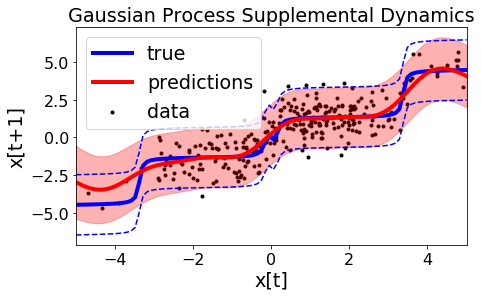

In [53]:
lw = 4
plt.figure(figsize=(7,4))
plt.plot(test_points, y_true, "b", lw=lw, label="true")
hi = y_true + 2 * np.sqrt(process_noise)
lo = y_true - 2 * np.sqrt(process_noise)
plt.plot(test_points, hi, "b--")
plt.plot(test_points, lo, "b--")
plt.scatter(x_data[:,0], y_data[:,0], c="k", marker=".", label="data")

plt.plot(test_points, predictions, "r", lw=lw, label="predictions")
hi = predictions + 2 * np.sqrt(uncertainties)
lo = predictions - 2 * np.sqrt(uncertainties)
plt.fill_between(test_points.flatten(), hi, lo, alpha=0.3, color="r")
plt.xlim(init_lims)
plt.legend()
plt.xlabel("x[t]")
plt.ylabel("x[t+1]")
plt.title("Gaussian Process Supplemental Dynamics")